In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.v2 as v2

In [2]:
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [3]:
# cleaning the dataframe
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
display(df)

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [4]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for i in df["Finding Labels"].unique():
    z=i.split("|")
    for j in z:
        diseases.add(j)
print(diseases)
for i in diseases:
    df.loc[:,i]=0

for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
display(df)

{'Cardiomegaly', 'Nodule', 'Pneumothorax', 'No Finding', 'Pneumonia', 'Fibrosis', 'Infiltration', 'Pleural_Thickening', 'Atelectasis', 'Effusion', 'Edema', 'Mass', 'Emphysema', 'Consolidation', 'Hernia'}


,Image Index,Cardiomegaly,Nodule,Pneumothorax,No Finding,Pneumonia,Fibrosis,Infiltration,Pleural_Thickening,Atelectasis,Effusion,Edema,Mass,Emphysema,Consolidation,Hernia
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,00000001_002.png,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,00000002_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
112116,00030802_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# # we now create the training data frame using the list provided in the files.
# image_names_train= open(r"train_val_list.txt").read().split("\n")
# for i in image_names_train:
#     df_train=df[df["Image Index"].isin(image_names_train)]
# df_train.to_parquet("df_train.parquet")

In [6]:
# # we now create the training data frame using the list provided in the files.
# image_names_test= open(r"test_list.txt").read().split("\n")
# for i in image_names_test:
#     df_test=df[df["Image Index"].isin(image_names_test)]
# df_test.to_parquet("df_test.parquet")

In [7]:
df_train=pd.read_parquet("df_train.parquet")

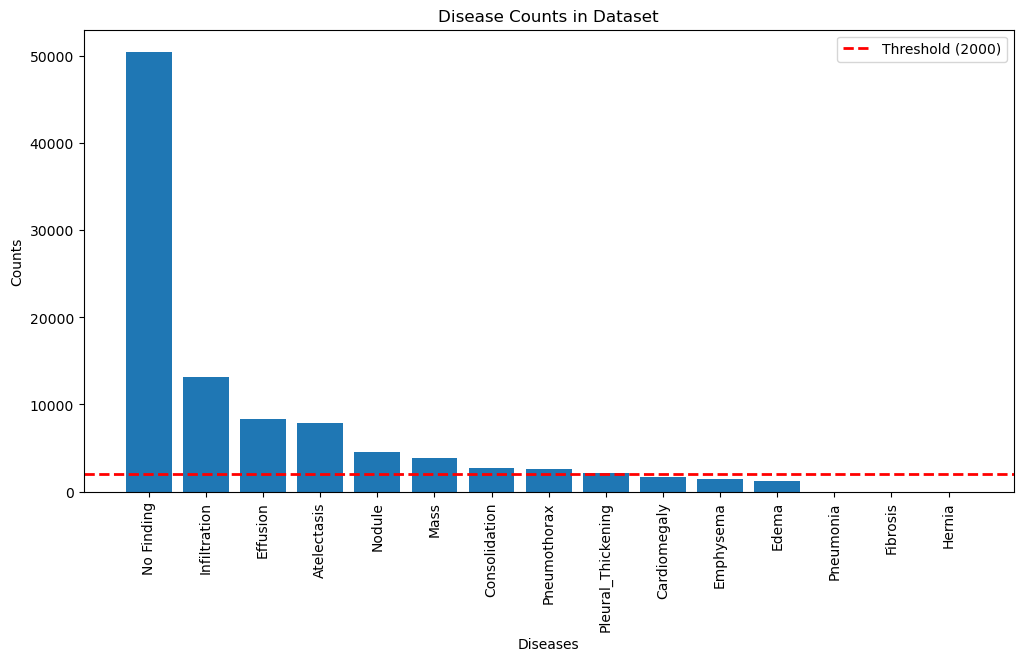

In [8]:
# We check to see how balanced the set is and check if any class is very underrepresented.
diseases=list(diseases)
counts=[df_train[i].sum() for i in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [9]:
# we remove diseases that are too rare.
rare_diseases=[i[0] for i in disease_counts if i[1]<2000]
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]

In [10]:
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]

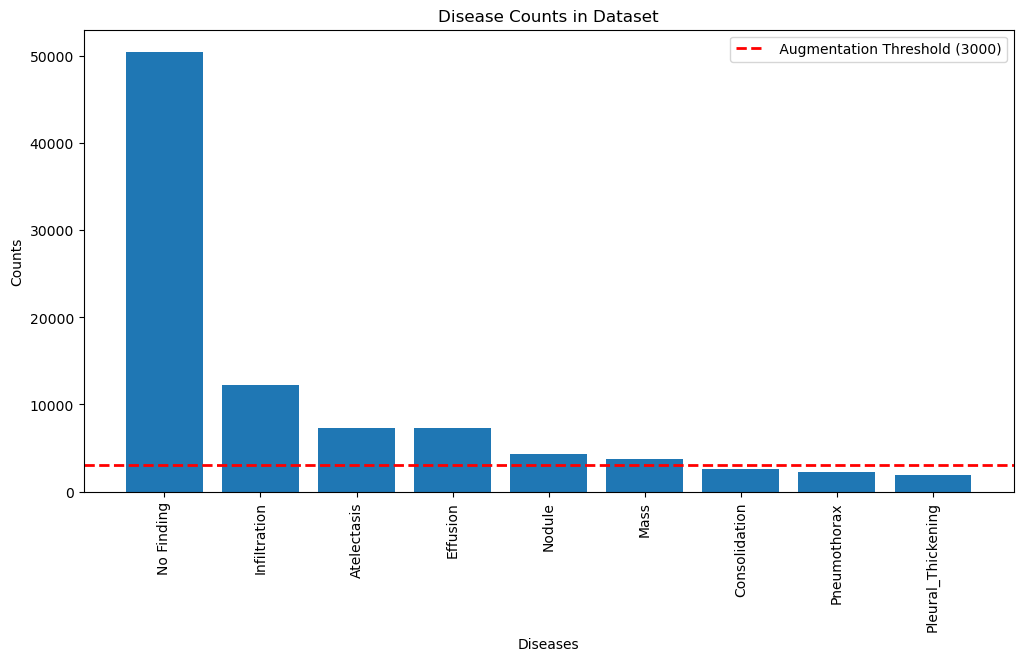

In [11]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=3000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (3000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [12]:
diseases_to_augment=[i[0] for i in common_disease_counts if i[1]<3000]

In [13]:
df_train_balanced=df_train.copy()
for disease in diseases_to_augment:
    df_disease = df_train[df_train[disease] == 1]
    num_to_add = 5000 - len(df_disease)
    
    df_augmented = pd.concat([df_disease] * (num_to_add // len(df_disease)) + [df_disease.sample(num_to_add % len(df_disease))])
    df_train_balanced = pd.concat([df_train_balanced, df_augmented])

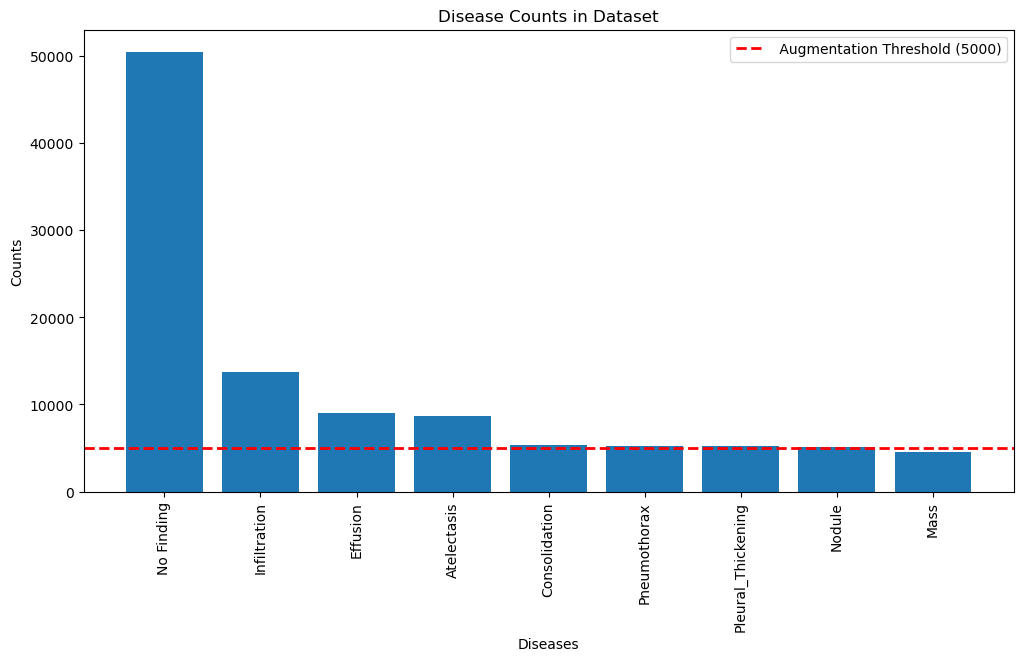

In [14]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train_balanced[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [15]:
df_train_balanced

,Image Index,Nodule,Pneumothorax,No Finding,Infiltration,Pleural_Thickening,Atelectasis,Effusion,Mass,Consolidation
3,00000002_000.png,0,0,1,0,0,0,0,0,0
12,00000004_000.png,1,0,0,0,0,0,0,1,0
13,00000005_000.png,0,0,1,0,0,0,0,0,0
14,00000005_001.png,0,0,1,0,0,0,0,0,0
15,00000005_002.png,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
80583,00019785_010.png,1,0,0,0,1,0,0,1,1
36680,00009658_002.png,0,0,0,0,1,1,0,1,0
7971,00002081_007.png,0,0,0,0,1,0,0,0,0
28476,00007428_011.png,0,0,0,0,1,0,1,0,0


In [16]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [17]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        if image_path is None:
            raise FileNotFoundError(f"Image {image_name} not found.")
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True),v2.Resize((224, 224)), 
    v2.RandomRotation(degrees=(-10,10)),v2.RandomHorizontalFlip(p=0.5), v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Create the dataset
dataset = XrayDataset(df_train_balanced, image_path_dict, transform=transform)

In [60]:
from sklearn.model_selection import train_test_split

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train_balanced, test_size=0.2, random_state=42)

# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True,num_workers=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [ ]:
import torch
import torch.nn as nn
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DenseNet121 as an example
num_classes = 9
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training step
def train_step(engine, batch):
    model.train()
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Define evaluation step
def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
    return outputs, labels

# Create Trainer and Evaluator engines
trainer = Engine(train_step)
evaluator = Engine(evaluate_step)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

def logits_transform(output):
    y_pred, y_true = output  # output is (logits, labels)
    y_pred = torch.sigmoid(y_pred)  # Convert logits to probabilities
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary (0 or 1)
    return y_pred, y_true  # Return binary predictions and original labels

# Attach Loss metric to evaluator to monitor validation loss
Loss(criterion).attach(evaluator, "val_loss")
Accuracy(output_transform=logits_transform).attach(evaluator, "accuracy")
Precision(output_transform=logits_transform,average=False).attach(evaluator, "precision")
Recall(output_transform=logits_transform).attach(evaluator, "Recall")
# Define EarlyStopping handler
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs to wait for improvement
    score_function=lambda engine: -engine.state.metrics["val_loss"],
    trainer=trainer
)
evaluator.add_event_handler(Events.COMPLETED, early_stopping)

# Run validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics["val_loss"]
    print(f"\nValidation Loss: {val_loss:.4f}")

# Run the training process
trainer.run(train_loader, max_epochs=5)



c:\Users\piotr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\piotr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/4418]   0%|           [00:00<?]


Validation Loss: 0.2888


[1/4418]   0%|           [00:00<?]


Validation Loss: 0.2810


[1/4418]   0%|           [00:00<?]


Validation Loss: 0.2786


[1/4418]   0%|           [00:00<?]


Validation Loss: 0.2729


[1/4418]   0%|           [00:00<?]


Validation Loss: 0.2716


State:
	iteration: 22090
	epoch: 5
	epoch_length: 4418
	max_epochs: 5
	output: 0.20015131599373287
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [63]:
torch.save(model.state_dict(), "best_model.pth")

In [73]:
Loss(criterion).attach(evaluator, "val_loss")
Accuracy(output_transform=logits_transform).attach(evaluator, "accuracy")
Precision(output_transform=logits_transform,average=False).attach(evaluator, "precision")
Recall(output_transform=logits_transform,average=False).attach(evaluator, "Recall")

In [ ]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
all_preds = []
all_labels = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Add this print to check if it's running

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    return outputs, labels
evaluator = Engine(evaluate_step)
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Run evaluation on test data
evaluator.run(test_loader)

# Concatenate all predictions and labels
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Reset for future use
all_preds, all_labels = [], []

# Compute detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(y_true.shape[1])]))

# Compute per-class precision, recall, F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nPer-Class Metrics:")
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")

# Optional: Confusion Matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print("\nConfusion Matrix:\n", cm)

Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224])
Processed batch with shape: torch.Size([128, 3, 224, 224

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
precision = precision_score(y_true, y_pred,average=None)
recall = recall_score(y_true, y_pred,average=None)
f1 = f1_score(y_true, y_pred,average=None)

In [98]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.01      0.02      1544
           1       0.00      0.00      0.00      2590
           2       0.65      0.51      0.57      9861
           3       0.46      0.10      0.16      5759
           4       0.15      0.00      0.01      1060
           5       0.66      0.01      0.03      3150
           6       0.59      0.18      0.28      4501
           7       0.45      0.06      0.11      1667
           8       0.25      0.00      0.00      1724

   micro avg       0.62      0.21      0.31     31856
   macro avg       0.42      0.10      0.13     31856
weighted avg       0.50      0.21      0.26     31856
 samples avg       0.27      0.25      0.25     31856



c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
evaluator.run(test_loader)
evaluator.state.metrics

# model.eval()  # Set the model to evaluation mode
# all_predictions = []
# all_labels = []

# with torch.no_grad():  # Disable gradient computation for faster inference
#     for images, labels in tqdm(test_loader, desc="Testing"):
#         images, labels = images.to(device), labels.to(device)
        
#         outputs = model(images)
#         predictions = torch.sigmoid(outputs)  # Convert logits to probabilities
        
#         all_predictions.append(predictions.cpu().numpy())
#         all_labels.append(labels.cpu().numpy())
# from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# all_predictions_concat = all_predictions.reshape(-1,9)
# all_labels =df_test.iloc[:,1:].values

# # Binary predictions (threshold = 0.5)
# binary_predictions = (all_predictions_concat > 0.5).astype(int)

# # Compute metrics
# accuracy = accuracy_score(all_labels, binary_predictions)
# auc = roc_auc_score(all_labels, all_predictions_concat, average="macro")  # For multi-label classification
# f1 = f1_score(all_labels, binary_predictions, average="macro")

# print(f"Accuracy: {accuracy:.4f}")
# print(f"AUC-ROC: {auc:.4f}")
# print(f"F1 Score: {f1:.4f}")

{'val_loss': 0.33833323564788387,
 'accuracy': 0.8669575144744353,
 'precision': 0.6151781582600648,
 'Recall': 0.2086577096936213}

In [39]:
from tqdm import tqdm

num_epochs = 2
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    # Add tqdm for the training loop
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation Phase with tqdm
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_densenet_model.pth")
        print("Model saved!")

    # Adjust the learning rate
    scheduler.step(avg_val_loss)

    # Display the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}\n")



Epoch [1/2]


Train Loss: 0.3356


Validation Loss: 0.2947
Model saved!
Current Learning Rate: 0.000100

Epoch [2/2]


Train Loss: 0.2921


Validation Loss: 0.2952
Current Learning Rate: 0.000100



In [40]:
pip install pytorch-ignite

Note: you may need to restart the kernel to use updated packages.


In [33]:
torch.cuda.empty_cache()

In [34]:
import gc

In [35]:
gc.collect()

0